In [1]:
c = 3e8  # speed of light (m/s)
fc = 10e9  # Carrier frequency: 10 GHz
wavelength = c / fc
bandwidth = 100e6  # 100 MHz
tx_power_dbm = 30  #  dBm
jam_power_dbm = 50
k = 1.38e-23  # Boltzmann 
GT = 13 # db gain-to-noise-temperature for for 0.33m Equivalent satellite antenna aperturesatellites, or can be 5 dB K^(-1) for 0.13m Equivalent satellite antenna aperture
La = 5 # dB
GT_linear_inv = 10 ** (-GT / 10)
La_linear = 10 ** (La / 10)
noise_power_watt = k * bandwidth * GT_linear_inv * La_linear
Tx_power_watt = 10 ** ((tx_power_dbm  - 30)/ 10)  
Jam_power_watt = 10 ** ((jam_power_dbm  - 30)/ 10)

In [2]:
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu, compute_az_el_dist
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from minmax_solvers import (
    solve_game_mirror_prox,
    solve_game_bestresp_Q0_then_Q1,
    solve_game_proxBR,
    solve_game_extragradient,
    solve_game_pdhg
)
# Your utils
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu
from sionna.rt import PlanarArray


import numpy as np
from numpy.linalg import cholesky, solve, eigh


# Generate RX positions

distances_km = [0.5]
azimuths_deg = np.linspace(0, 360, len(distances_km), endpoint=False)
gnd_positions = [np.array([0.0, 0.0, 0.0])]

for d_km, az in zip(distances_km, azimuths_deg):
    pos = arc_point_on_earth(d_km, az)
    gnd_positions.append(pos)
gnd_positions = np.array(gnd_positions)

for i, pos in enumerate(gnd_positions):
    print(f"TX{i}(m): {pos}")


# Compute SAT intersection points

sat_orbit_m = 550e3
# angles = [(120, 80),(45, 90), (75,75),(80,88), (65, 85),(130,75)]
angles = [(1, 90-(1e-3)), (60, 87), (120,84),(180,80), (240, 82),(300,80)]
# angles = [(45, 90-(1e-3)), (120, 87), (75,85),(80,83), (65, 82),(130,80)]
# angles = [(45, 90-(1e-3)), (220, 87), (75,85)]
sat_positions = []
delays_ms = []
fspl_db = []
frequency_hz = 10e9 
wavelength = 3e8 / frequency_hz

for az, el in angles:
    pos, delay, dist = compute_satellite_intersection_point_enu(az, el, sat_orbit_m)
    sat_positions.append(pos)
    delays_ms.append(delay)
    fspl = 20 * np.log10(4 * np.pi * dist / wavelength)
    fspl_db.append(fspl)

sat_positions = np.array(sat_positions)
delays_ms = np.array(delays_ms)
fspl_db = np.array(fspl_db)

print("\nSatellite Pos [m]:\n", sat_positions)
# print("\nPropagation delays [ms]:\n", delays_ms)
# print("\nFree-space path loss [dB]:\n", fspl_db)


# Compute az/el/dist per TX-SAT
  
for i, tx in enumerate(gnd_positions):
    print(f"\nFrom TX{i}:")
    for j, sat in enumerate(sat_positions):
        az, el, dist, n_waves = compute_az_el_dist(sat, tx, frequency_hz)
        print(f"  SAT{j}: az={az:.2f}°, el={el:.2f}°, dist={dist:.2f} m, λ count ≈ {n_waves:.2f}")


jitc_llvm_init(): LLVM API initialization failed ..


TX0(m): [0. 0. 0.]
TX1(m): [ 3.06161699e-14  4.99999999e+02 -1.96201537e-02]

Satellite Pos [m]:
 [[ 1.67531075e-01  9.59784887e+00  5.50000000e+05]
 [ 2.49598339e+04  1.44105668e+04  5.49939990e+05]
 [ 5.00406602e+04 -2.88909887e+04  5.49758791e+05]
 [-1.77929524e-11 -9.68603215e+04  5.49322180e+05]
 [-6.68891070e+04 -3.86184439e+04  5.49569013e+05]
 [-8.38834990e+04  4.84301607e+04  5.49322180e+05]]

From TX0:
  SAT0: az=1.00°, el=90.00°, dist=550000.00 m, λ count ≈ 18333333.34
  SAT1: az=60.00°, el=87.00°, dist=550694.70 m, λ count ≈ 18356489.92
  SAT2: az=120.00°, el=84.00°, dist=552787.02 m, λ count ≈ 18426233.87
  SAT3: az=180.00°, el=80.00°, dist=557796.36 m, λ count ≈ 18593212.01
  SAT4: az=240.00°, el=82.00°, dist=554969.94 m, λ count ≈ 18498998.08
  SAT5: az=300.00°, el=80.00°, dist=557796.36 m, λ count ≈ 18593212.01

From TX1:
  SAT0: az=179.98°, el=89.95°, dist=550000.24 m, λ count ≈ 18333341.27
  SAT1: az=60.87°, el=87.03°, dist=550681.86 m, λ count ≈ 18356062.01
  SAT2: a

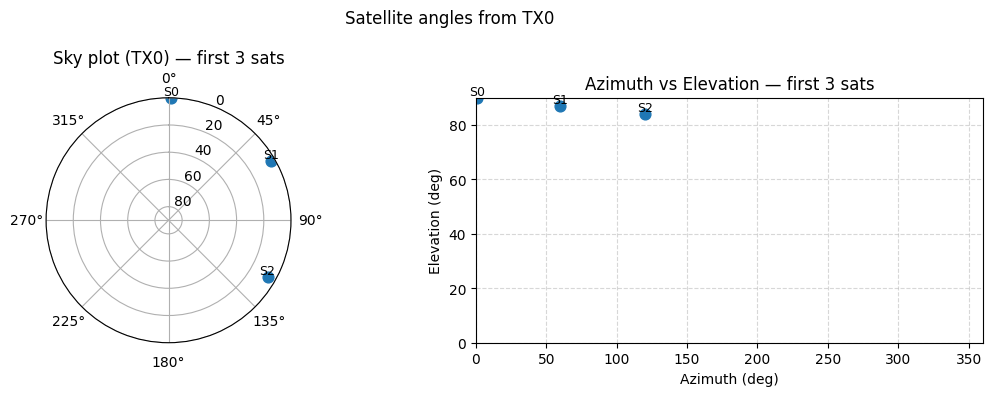

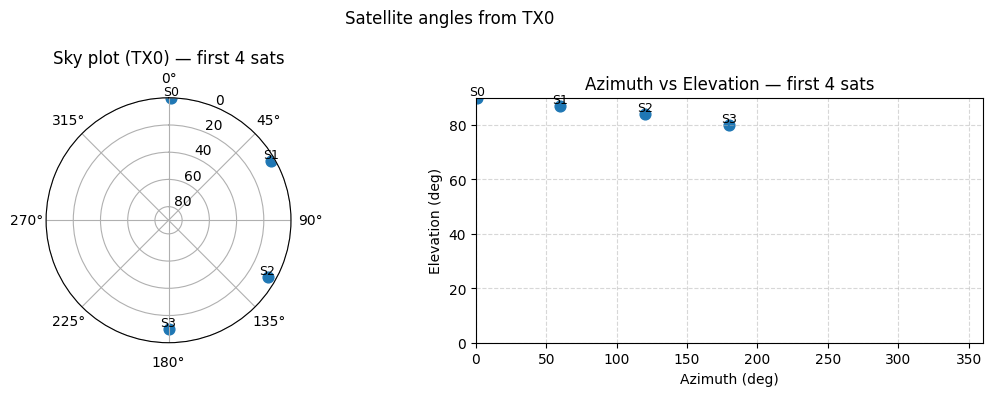

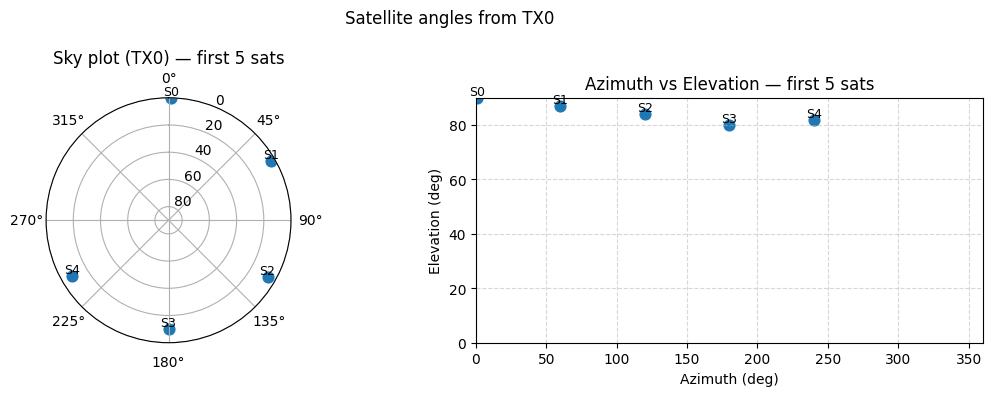

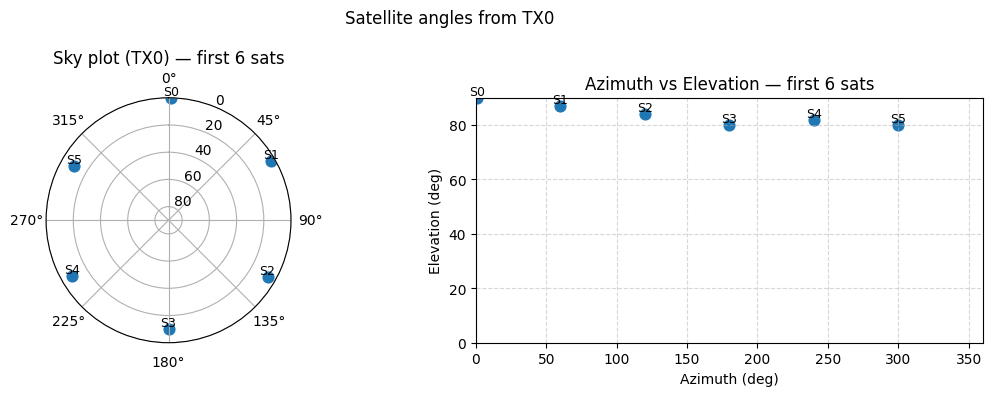

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Choose which ground TX viewpoint to use (0 = first one you printed)
tx_idx = 0  

def sats_az_el_for_k(k, tx_pos):
    az_list, el_list = [], []
    for j in range(k):
        az, el, dist, n_waves = compute_az_el_dist(sat_positions[j], tx_pos, frequency_hz)
        az_list.append(az)
        el_list.append(el)
    return np.array(az_list), np.array(el_list)

# Make four figures for k = 3,4,5,6
for k in [3, 4, 5, 6]:
    az, el = sats_az_el_for_k(k, gnd_positions[tx_idx])

    fig = plt.figure(figsize=(11, 4))

    # ---- (Left) Polar sky plot: radius = 90 - elevation (0 at zenith) ----
    ax1 = plt.subplot(1, 2, 1, projection='polar')
    theta = np.deg2rad(az)                 # azimuth in radians
    r = 90.0 - el                          # zenith angle
    sc = ax1.scatter(theta, r, s=60)
    # Annotate satellite indices
    for j in range(k):
        ax1.text(theta[j], r[j], f"S{j}", ha='center', va='bottom', fontsize=9)
    ax1.set_rlim(90, 0)                    # zenith at center
    ax1.set_theta_zero_location("N")       # 0° at North (up)
    ax1.set_theta_direction(-1)            # azimuth increasing clockwise
    ax1.set_title(f"Sky plot (TX{tx_idx}) — first {k} sats")

    # ---- (Right) Cartesian azimuth vs elevation ----
    ax2 = plt.subplot(1, 2, 2)
    ax2.scatter(az, el, s=60)
    for j in range(k):
        ax2.text(az[j], el[j], f"S{j}", ha='center', va='bottom', fontsize=9)
    ax2.set_xlim(0, 360)
    ax2.set_ylim(0, 90)
    ax2.set_xlabel("Azimuth (deg)")
    ax2.set_ylabel("Elevation (deg)")
    ax2.grid(True, linestyle='--', alpha=0.5)
    ax2.set_title(f"Azimuth vs Elevation — first {k} sats")

    plt.suptitle(f"Satellite angles from TX{tx_idx}")
    plt.tight_layout()
    plt.show()


In [4]:
from sionna.rt import Scene, Receiver, Transmitter, PlanarArray, PathSolver
import numpy as np

def compute_cir(tx_pos, rx_pos, tx_array, rx_array,tx_look_at, rx_look_at, frequency=10e9):
    """
    Compute CIR from a single transmitter to multiple receivers using synthetic arrays.
    
    Args:
        tx_pos:        (3,) list or np.array for transmitter position
        rx_pos_array:  (m,3) array of receiver positions
        tx_array:      PlanarArray for the transmitter
        rx_array:      PlanarArray for all receivers (shared)
        frequency:     Frequency in Hz

    Returns:
        a_list:    list of CIR amplitude arrays, one per RX
        tau_list:  list of delay arrays, one per RX
    """
    scene = Scene()
    scene.frequency = frequency
    scene.synthetic_array = True

    # Add transmitter
    scene.tx_array = tx_array
    tx = Transmitter(name="tx", position=tx_pos, display_radius=200)
    scene.add(tx)

    # Add receivers
    scene.rx_array = rx_array
    rx_list = []
    for i, rx_pos in enumerate(rx_pos):
        rx = Receiver(name=f"rx{i}", position=rx_pos)
        scene.add(rx)
        rx.look_at(rx_look_at)
        rx_list.append(rx)

    tx.look_at(tx_look_at)  # Point TX to the first RX

    # Solve paths
    solver = PathSolver()
    paths = solver(scene=scene,
                   max_depth=0,
                   los=True,
                   synthetic_array=True,
                   seed=41)

    # Get CIRs
    a_all, tau_all = paths.cir(normalize_delays=False, out_type="numpy")

    for tx_name in scene.transmitters:
        scene.remove(tx_name)
    for rx_name in scene.receivers:
        scene.remove(rx_name) 
    
    return a_all, tau_all


In [5]:
import vsat_dish_3gpp
jam_rows =8
jam_cols = 8
jam_antennas = jam_cols*jam_rows

sat_rows = 1
sat_cols = 1
sat_antennas = sat_cols*sat_rows

tx_rows = 8
tx_cols = 8
tx_antennas = tx_cols*tx_rows

tx_array = PlanarArray(num_rows=tx_rows, num_cols=tx_cols,
                        vertical_spacing=0.5, horizontal_spacing=0.5,
                        pattern="tr38901", polarization="V")
                        # pattern="iso", polarization="V")

jam_array = PlanarArray(num_rows=jam_rows, num_cols=jam_cols,  
                            vertical_spacing=0.5, horizontal_spacing=0.5,
                        #  pattern="vsat_dish",
                            pattern="tr38901",
                            polarization="V")

sat_array = PlanarArray(num_rows=sat_rows, num_cols=sat_cols,
                             vertical_spacing=0.5, horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")




In [6]:
import numpy as np
from numpy.linalg import cholesky, solve, eigh

def collapse_channel(a_cir, t_idx=0):
    """
    Collapse channel tensor at a given time index.
    Input:
      a_cir: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
    Output:
      H_t: (M, N), M = num_rx*num_rx_ant, N = num_tx*num_tx_ant
    """
    nr, nra, nt, nta, npaths, ntimes = a_cir.shape
    assert 0 <= t_idx < ntimes
    H_t = a_cir[..., t_idx]             # select time slice
    H_t = H_t.sum(axis=-1)              # sum over paths
    H_t = H_t.reshape(nr*nra, nt*nta)   # merge Rx/Tx antennas
    return H_t




In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from minmax_solvers import (
    solve_game_mirror_prox,
    solve_game_bestresp_Q0_then_Q1,
    solve_game_proxBR,
    solve_game_extragradient,
    solve_game_pdhg
)
# Your utils
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu
from sionna.rt import PlanarArray
# from your_module import compute_cir, collapse_channel   # replace with your implementation



# -------------------------
# Experiment configuration
# -------------------------
methods = ["BestResp", "MirrorProx", "ProxBR"]
sat_counts = [1, 2, 3, 4, 5, 6]
results = {m: {} for m in methods}

# -------------------------
# Main loop
# -------------------------
for m in methods:
    for k in tqdm(sat_counts, desc=f"Method={m}"):
        # Select the first k satellites
        sat_positions = []
        for az, el in angles[:k]:
            pos, delay, dist = compute_satellite_intersection_point_enu(az, el, sat_orbit_m)
            sat_positions.append(pos)
        sat_positions = np.array(sat_positions)

        # Build the channels
        a_tx, tau_tx = compute_cir(gnd_positions[0], sat_positions, tx_array, sat_array,
                                   sat_positions[0], gnd_positions[0])
        a_jam, tau_jam = compute_cir(gnd_positions[1], sat_positions, tx_array, sat_array,
                                     sat_positions[0], gnd_positions[0])
        H0 = collapse_channel(a_tx)
        H1 = collapse_channel(a_jam)

        N0 = noise_power_watt
        P0 = Tx_power_watt
        P1 = Jam_power_watt
        n1 = H1.shape[1]
        Q1_init = (P1/n1) * np.eye(n1, dtype=complex)

        # Run different solvers
        if m == "BestResp":
            Q0, Q1, n_it, hist = solve_game_bestresp_Q0_then_Q1(
                H0, H1, N0,
                P0=P0, P1=P1,
                max_outer=1000, tol=1e-6, inner_Q1_steps=4,
                geometry='entropy',        # 'euclidean' → Extragradient; 'entropy' → Mirror-Prox
                step_rule='adp',           # 'fixed' → fixed step size; 'adp' → adaptive step size
                eta=0.5,                   # used only when step_rule='fixed'
                eta_init=0.3,              # initial step size for adaptive mode
                eta_min=1.5e-1, eta_max=0.9, # range of step size for adaptive mode
                beta=0.1, gamma=1.01,      # backtracking shrink/expand factors
                multi_stream=True,         # multi-stream water-filling for Q0
                verbose=True,              # print progress
                track_hist=True,           # record history curves
                Q1_init=Q1_init
            )
            results[m][k] = hist

        elif m == "MirrorProx":
            Q0, Q1, hist = solve_game_mirror_prox(
                H0, H1, N0, P0, P1,
                steps=8000,
                eta=0.25,                  # step size (try between 0.2–0.4)
                step_rule='adp',           # 'adp' (adaptive) is usually faster; fallback to 'fixed' if unstable
                beta=0.3, gamma=1.03,      # shrink/expand factors
                eta_min=1e-3, eta_max=1.0,
                strong_reg=0.0,            # if unstable, set ~1e-3
                Q0_init=None, Q1_init=Q1_init,
                use_averaging=True,
                eta_probe=0.2,
                verbose=True, track_hist=True
            )
            results[m][k] = hist

        elif m == "ProxBR":
            Q0, Q1, hist = solve_game_proxBR(
                H0, H1, N0, P0, P1,
                rho=1e-2,
                outer_steps=400, outer_tol=1e-6,
                inner_max=200, inner_tol=1e-6,
                eta0_inner=0.5,            # initial step size for inner updates
                beta=0.5, gamma=1.1,       # backtracking shrink/expand
                eta_min=1e-2, eta_max=1.0,
                eta_probe=0.1,             # step size for residual evaluation (“thermometer”)
                min_outer=5,               # prevent early stop at iteration 1
                verbose=True, track_hist=True
            )
            results[m][k] = hist


Method=BestResp:   0%|          | 0/6 [00:00<?, ?it/s]

[outer 1] errQ0=nan, errQ1=3.219e-02, res=3.284e-02, J=0.5874, eta=0.312, trQ1=100.000000
[outer 2] errQ0=1.745e-15, errQ1=2.981e-02, res=2.912e-02, J=0.5098, eta=0.325, trQ1=100.000000
[outer 3] errQ0=8.339e-16, errQ1=2.801e-02, res=2.630e-02, J=0.4535, eta=0.338, trQ1=100.000000
[outer 4] errQ0=5.846e-16, errQ1=2.662e-02, res=2.407e-02, J=0.4104, eta=0.352, trQ1=100.000000
[outer 5] errQ0=6.055e-16, errQ1=2.553e-02, res=2.224e-02, J=0.3761, eta=0.366, trQ1=100.000000
[outer 6] errQ0=1.039e-15, errQ1=2.465e-02, res=2.071e-02, J=0.3480, eta=0.381, trQ1=100.000000
[outer 7] errQ0=9.513e-16, errQ1=2.393e-02, res=1.940e-02, J=0.3243, eta=0.396, trQ1=100.000000
[outer 8] errQ0=6.635e-16, errQ1=2.333e-02, res=1.826e-02, J=0.3041, eta=0.412, trQ1=100.000000
[outer 9] errQ0=9.568e-16, errQ1=2.283e-02, res=1.726e-02, J=0.2866, eta=0.429, trQ1=100.000000
[outer 10] errQ0=1.065e-15, errQ1=2.241e-02, res=1.637e-02, J=0.2711, eta=0.447, trQ1=100.000000
[outer 11] errQ0=8.165e-16, errQ1=2.206e-02, 

Method=MirrorProx:   0%|          | 0/6 [00:00<?, ?it/s]

[0001] J=0.0164, errQ0=2.60e-03, errQ1=2.20e-04, res=3.01e-03, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0002] J=0.0190, errQ0=3.00e-03, errQ1=2.55e-04, res=3.48e-03, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0003] J=0.0220, errQ0=3.46e-03, errQ1=2.95e-04, res=4.01e-03, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0004] J=0.0255, errQ0=3.99e-03, errQ1=3.41e-04, res=4.61e-03, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0005] J=0.0294, errQ0=4.58e-03, errQ1=3.93e-04, res=5.28e-03, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0006] J=0.0338, errQ0=5.24e-03, errQ1=4.52e-04, res=6.02e-03, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0007] J=0.0388, errQ0=5.98e-03, errQ1=5.18e-04, res=6.85e-03, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0008] J=0.0445, errQ0=6.80e-03, errQ1=5.91e-04, res=7.76e-03, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0009] J=0.0508, errQ0=7.69e-03, errQ1=6.73e-04, res=8.75e-03, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0010] J=0.0577, errQ0=8.66e-03, errQ1=7.64e-04, res=9.82e-03, eta=0.25, trQ0=1.00

Method=ProxBR:   0%|          | 0/6 [00:00<?, ?it/s]

[001] J=0.2661, errQ0=1.00e+00, errQ1=4.91e+00, res=3.41e-02, trQ1=4.9093
[002] J=0.1997, errQ0=4.37e-16, errQ1=3.66e-01, res=1.92e-02, trQ1=6.7077
[003] J=0.1699, errQ0=4.54e-16, errQ1=1.89e-01, res=1.39e-02, trQ1=7.9732
[004] J=0.1520, errQ0=6.44e-16, errQ1=1.25e-01, res=1.11e-02, trQ1=8.9715
[005] J=0.1397, errQ0=6.77e-16, errQ1=9.32e-02, res=9.38e-03, trQ1=9.8073
[010] J=0.1084, errQ0=4.35e-16, errQ1=4.02e-02, res=5.65e-03, trQ1=12.7904
[020] J=0.0849, errQ0=8.64e-16, errQ1=1.86e-02, res=3.46e-03, trQ1=16.4772
[030] J=0.0738, errQ0=1.16e-15, errQ1=1.21e-02, res=2.62e-03, trQ1=19.0354
[040] J=0.0669, errQ0=5.95e-16, errQ1=8.91e-03, res=2.15e-03, trQ1=21.0618
[050] J=0.0620, errQ0=3.59e-16, errQ1=7.06e-03, res=1.84e-03, trQ1=22.7678
[060] J=0.0582, errQ0=5.41e-16, errQ1=5.84e-03, res=1.63e-03, trQ1=24.2561
[070] J=0.0553, errQ0=3.15e-16, errQ1=4.98e-03, res=1.47e-03, trQ1=25.5850
[080] J=0.0528, errQ0=1.01e-15, errQ1=4.34e-03, res=1.34e-03, trQ1=26.7913
[090] J=0.0508, errQ0=4.22e-16

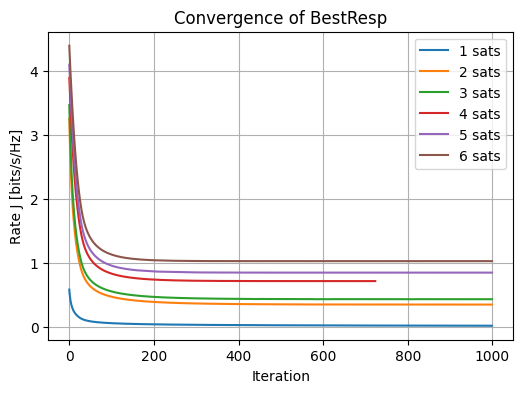

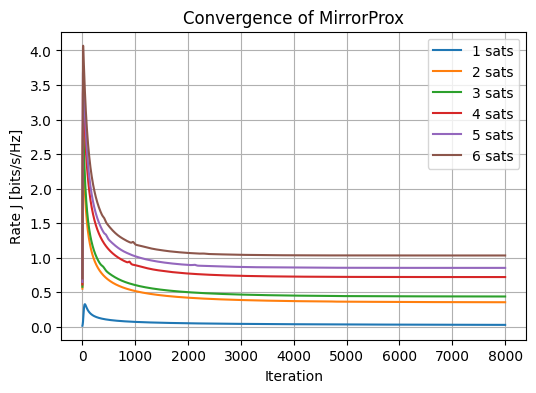

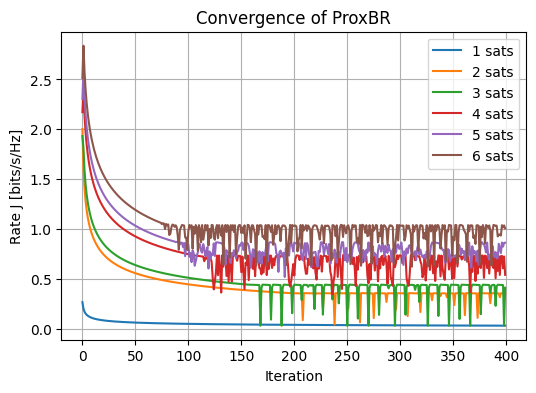

In [8]:

# # -------------------------
# # Plot for convergence
# # -------------------------
for m in methods:
    plt.figure(figsize=(6,4))
    for k in sat_counts:
        hist = results[m][k]
        plt.plot(hist['J'], label=f"{k} sats")
    plt.xlabel("Iteration")
    plt.ylabel("Rate J [bits/s/Hz]")
    plt.title(f"Convergence of {m}")
    plt.legend()
    plt.grid(True)
    plt.show()


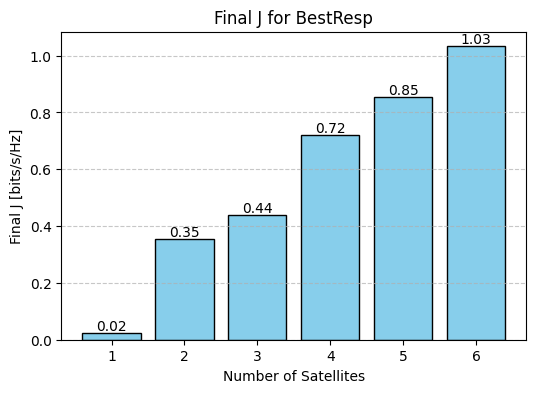

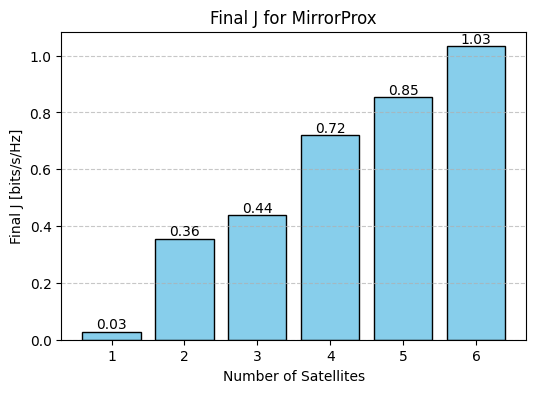

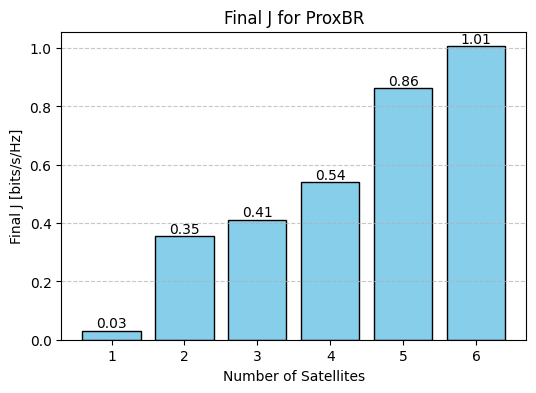

In [10]:
import matplotlib.pyplot as plt
import numpy as np

sat_counts = [1, 2, 3, 4, 5, 6]
methods = ["BestResp", "MirrorProx", "ProxBR"]

for m in methods:
    final_J = [results[m][k]['J'][-1] for k in sat_counts]
    plt.figure(figsize=(6,4))
    plt.bar([str(k) for k in sat_counts], final_J, color="skyblue", edgecolor="k")
    plt.xlabel("Number of Satellites")
    plt.ylabel("Final J [bits/s/Hz]")
    plt.title(f"Final J for {m}")
    for i, v in enumerate(final_J):
        plt.text(i, v, f"{v:.2f}", ha="center", va="bottom", fontsize=10)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()
